# **STEP 1: PROJECT DESCRIPTION & DATASET**

This project utilizes deep learning models to forecast national electricity demand based on key meteorological and societal variables. The dataset, sourced from the [Electricity Load Forecasting](https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting) competition on Kaggle, covers data from Panama for the years 2015 to 2020. It includes hourly weather data such as temperature, humidity, wind speed, and precipitation, as well as additional features like whether the day is a holiday or a school day. With over 48,000 data entries, this dataset captures factors that influence electricity demand, helping to model and predict grid load more accurately.

In the first phase of the project, we will conduct an exploratory data analysis (EDA) to clean and visualize the data, gaining insights into its key characteristics. After splitting the dataset into training and test sets, we will apply Long Short-Term Memory (LSTM) deep learning models, experimenting with various hyperparameter combinations. Hyperparameter optimization will be conducted using the Keras Tuner to identify the best model based on the lowest validation loss and mean squared error (MSE). The selected model will then be trained and evaluated on the test set.

Accurate electricity load forecasting is critical for effective grid management. It ensures that electricity supply meets demand efficiently, reducing costs while improving reliability. By developing deep learning models to predict national demand with high accuracy, governments and private enterprises can optimize resource allocation and ensure a stable energy supply for consumers.


In [ ]:
# Install keras tuner package
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# URL of Google Drive file
file_id_continuous = '1VNeF2zAFA8YrxLLPDVhFZpJ0qQfoaQuA'
url_continuous = f'https://drive.google.com/uc?export=download&id={file_id_continuous}'

# Download the file
gdown.download(url_continuous, 'continuous_dataset.csv', quiet=False)

# Load the dataset
continuous_data = pd.read_csv('continuous_dataset.csv', parse_dates=['datetime'], index_col='datetime')

Downloading...
From: https://drive.google.com/uc?export=download&id=1VNeF2zAFA8YrxLLPDVhFZpJ0qQfoaQuA
To: /content/continuous_dataset.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 31.8MB/s]


# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**
The first step in this project involves uncovering trends, patterns, and gaining a general understanding of the dataset through exploratory data analysis (EDA). After downloading the dataset, we begin by summarizing its shape and structure. We discover 48,048 hourly entries spanning the years 2015 to 2020 with no missing values. However, to fully interpret the data, we investigate the meaning of the feature names and their abbreviations. Through [Kaggle’s discussion forum](https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting/discussion/360094), we clarify the following:
<br><br>
### **Feature Definitions:**
* **nat_demand:** National electricity load
* **T2M:** Temperature at 2 meters
* **QV2M:** Relative humidity at 2 meters
* **TQL:** Liquid precipitation
* **W2M:** Wind speed at 2 meters

**City Codes:**

* **toc:** Tocumen, Panama City
* **san:** Santiago City
* **dav:** David City

**Other Variables:**

* **Holiday_ID:** Unique holiday identification number
* **holiday:** Holiday binary indicator (1 = holiday, 0 = regular day)
* **school:** School period binary indicator (1 = school, 0 = vacation)

<br><br>
With no missing values, we proceed to visualize key relationships in the data. The following insights emerge:
<br><br>
1. **National Demand with 48-Hour Moving Average:**

* Periodic fluctuations are evident, though the mean values remain within a relatively narrow range. Seasonal and daily trends likely contribute to the wide range of values over time.

2. **National Demand for the Last 7 Days:**
* Significant daily and weekly trends are observed, reinforcing the importance of accounting for these cycles during data preparation.

3. **Distribution of National Demand:**
* A histogram reveals a near-normal distribution with mild skewness. The majority of demand falls within the 750 to 1750 range.

4. **Average National Demand by Day of Week and Hour:**
* A heatmap highlights daily cycles of energy use, with peaks occurring around midday to early afternoon. Demand is consistently higher on weekdays compared to weekends, aligning with industrial and commercial activity patterns.

<br><br>
### **Data Preparation**

We continue by preparing the data for our LSTM model training. To facilitate this, we:
<br><br>
1. **Divide the Data:**
* Divide the dataset into an 80% training set and 20% test set to evaluate our training model after.
2. **Scale the Data:**
* Normalize all features to a 0–1 range using the MinMaxScaler method, ensuring compatibility with deep learning models.
3. **Generate Batches:**
* Divide the data into batches of 5000 sequences. Input-output sequences are created for LSTM training, with input sequences representing hourly trends over 24-hour periods.

<br><br>
Finally, the batched sequences are concatenated into a single dataset to optimize computational efficiency. With this preparation complete, we transition to the next phase of the project: modeling and hyperparameter tuning.


In [ ]:
# Inspect the data
print(continuous_data.head())

                     nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                    
2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

                       T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
datetime                                                                   
2015-01-03 01:00:00  23.482446  0.017272  0.001855  10.328949  22.662134   
2015-01-03 02:00:00  23.399255  0.017265  0.001327  10.681517  22.578943   
2015-01-03 03:00:00  23.343530  0.017211  0.001428  10.874924  22.531030   
2015-01-03 04:00:00  23.238794  0.017128  0.002599  10.518620  22.512231   
2015

In [ ]:
continuous_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48048 entries, 2015-01-03 01:00:00 to 2020-06-27 00:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nat_demand  48048 non-null  float64
 1   T2M_toc     48048 non-null  float64
 2   QV2M_toc    48048 non-null  float64
 3   TQL_toc     48048 non-null  float64
 4   W2M_toc     48048 non-null  float64
 5   T2M_san     48048 non-null  float64
 6   QV2M_san    48048 non-null  float64
 7   TQL_san     48048 non-null  float64
 8   W2M_san     48048 non-null  float64
 9   T2M_dav     48048 non-null  float64
 10  QV2M_dav    48048 non-null  float64
 11  TQL_dav     48048 non-null  float64
 12  W2M_dav     48048 non-null  float64
 13  Holiday_ID  48048 non-null  int64  
 14  holiday     48048 non-null  int64  
 15  school      48048 non-null  int64  
dtypes: float64(13), int64(3)
memory usage: 6.2 MB


In [ ]:
# Check for any missing values
print("Missing values per column in continuous data:")
print(continuous_data.isnull().sum())

Missing values per column in continuous data:
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64


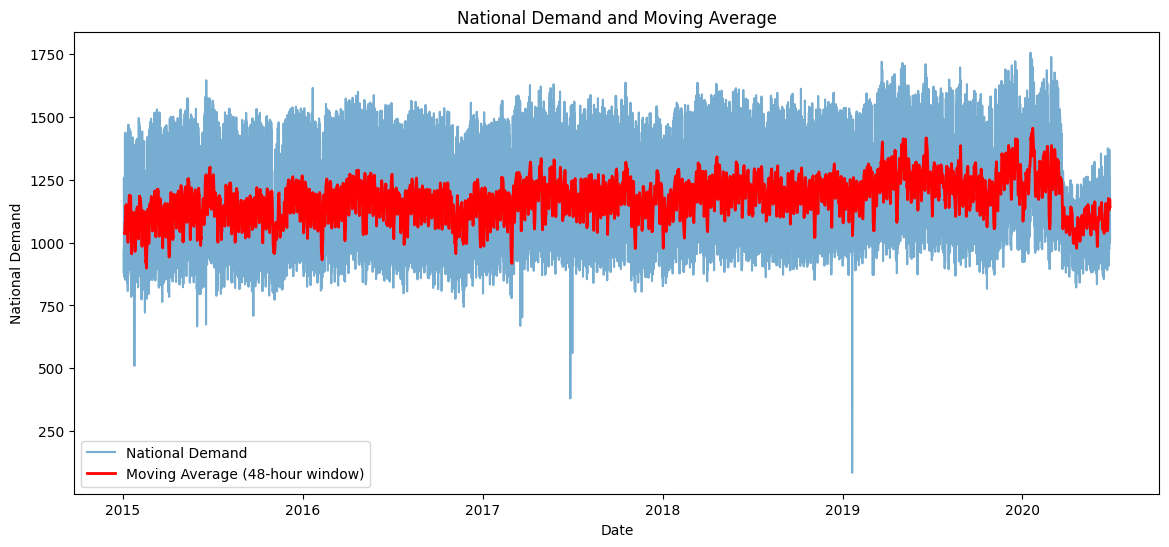

In [ ]:
# Plot moving average of national demand
rolling_mean = continuous_data['nat_demand'].rolling(window=48).mean()
plt.figure(figsize=(14, 6))
plt.plot(continuous_data['nat_demand'], label='National Demand', alpha=0.6)
plt.plot(rolling_mean, label='Moving Average (48-hour window)', color='red', linewidth=2)
plt.title("National Demand and Moving Average")
plt.xlabel("Date")
plt.ylabel("National Demand")
plt.legend()
plt.show()

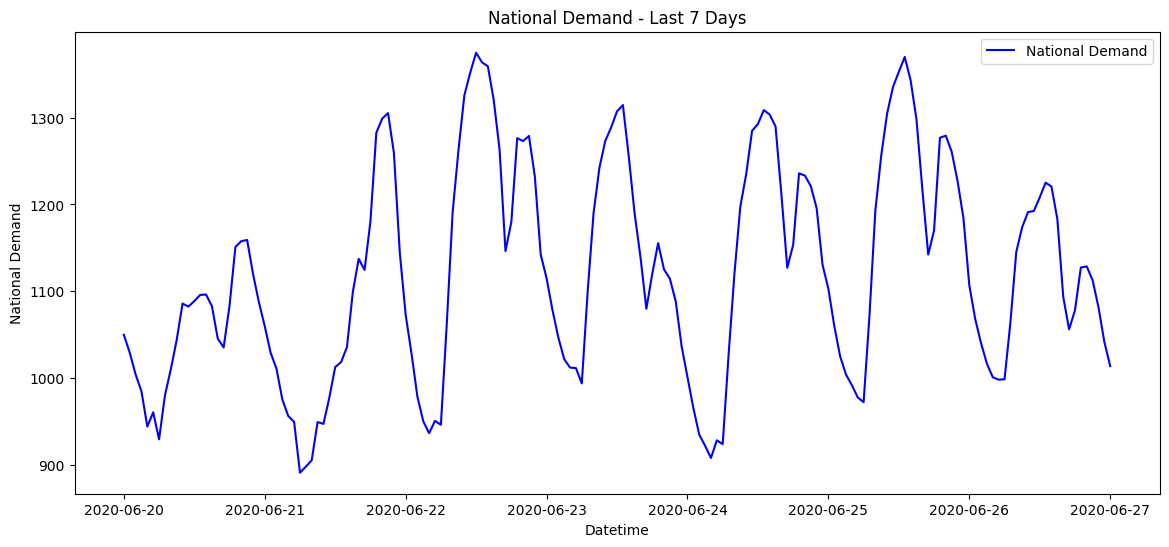

In [ ]:
# Plot the last 7 days of national demand
plt.figure(figsize=(14, 6))
plt.plot(continuous_data.loc[continuous_data.index >= continuous_data.index[-1] - pd.Timedelta(days=7), 'nat_demand'],
         label='National Demand', color='blue')
plt.title("National Demand - Last 7 Days")
plt.xlabel("Datetime")
plt.ylabel("National Demand")
plt.legend()
plt.show()

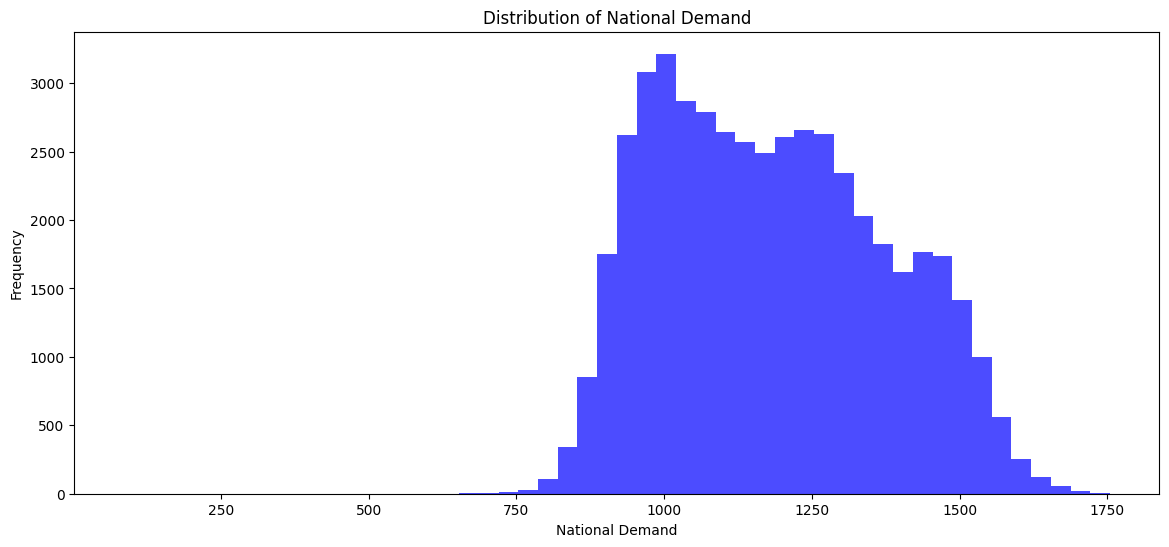

In [ ]:
# Plot distribution of national demand
plt.figure(figsize=(14, 6))
plt.hist(continuous_data['nat_demand'], bins=50, color='blue', alpha=0.7)
plt.title("Distribution of National Demand")
plt.xlabel("National Demand")
plt.ylabel("Frequency")
plt.show()

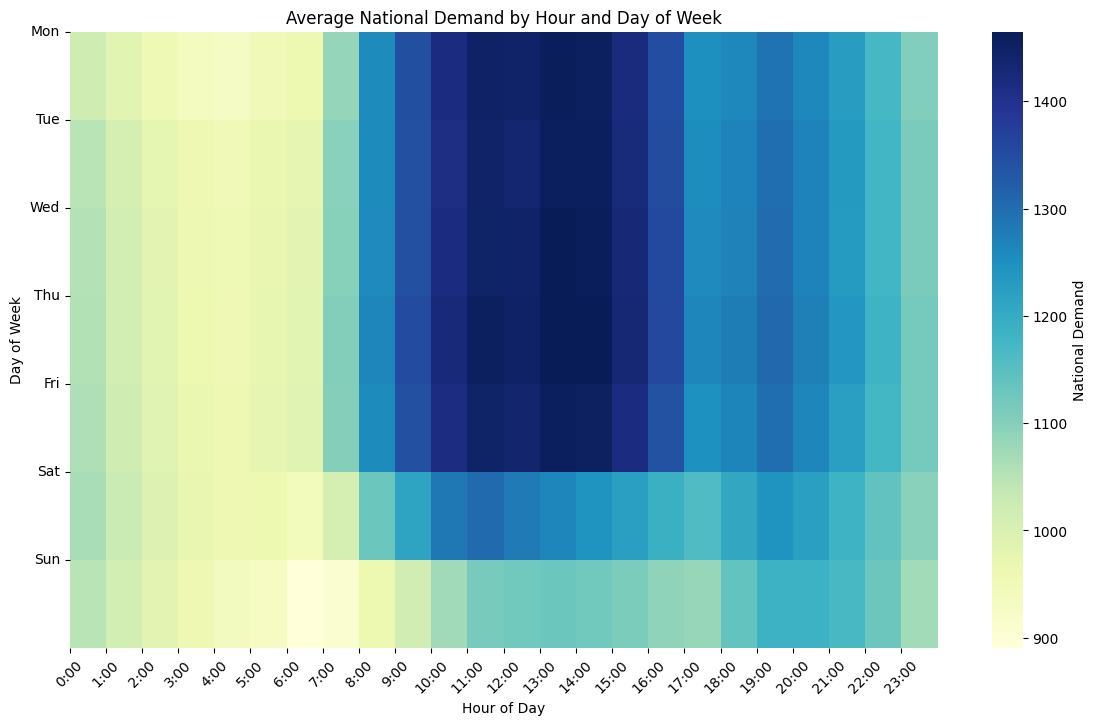

In [ ]:
# Plot national demand by hour of the day and day of week
continuous_data['hour'] = continuous_data.index.hour
continuous_data['day_of_week'] = continuous_data.index.dayofweek

# Pivot the data for the heatmap
demand_by_hour_day = continuous_data.pivot_table(index='day_of_week', columns='hour', values='nat_demand', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(demand_by_hour_day, cmap="YlGnBu", annot=False, cbar_kws={'label': 'National Demand'})
plt.title("Average National Demand by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.xticks(range(0, 24), labels=[f'{i}:00' for i in range(24)], rotation=45)
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

In [ ]:
# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(split_ratio * len(continuous_data))
train_data = continuous_data.iloc[:split_idx]
test_data = continuous_data.iloc[split_idx:]

In [ ]:
# Function to scale data incrementally
def scale_data_in_batches(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return scaled_data, scaler

# Scale train and test data
train_data_scaled, scaler = scale_data_in_batches(train_data)
test_data_scaled, _ = scale_data_in_batches(test_data, scaler)

# Generator to create sequences incrementally
def sequence_batch_generator(data, target_column, time_steps=24, batch_size=5000):
    num_batches = (len(data) - time_steps) // batch_size + 1
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(len(data), start_idx + batch_size + time_steps)

        # Generate sequences within the batch
        X_batch, y_batch = [], []
        for i in range(start_idx, end_idx - time_steps):
            X_batch.append(data.iloc[i:i+time_steps].values)
            y_batch.append(data.iloc[i+time_steps][target_column])

        yield np.array(X_batch), np.array(y_batch)

# Process the data in batches for LSTM
time_steps = 24
batch_size = 5000
#continuous_data_scaled, scaler = scale_data_in_batches(continuous_data)

X_train_list, y_train_list = [], []
for X_batch, y_batch in sequence_batch_generator(train_data_scaled, target_column='nat_demand', time_steps=time_steps, batch_size=batch_size):
    X_train_list.append(X_batch)
    y_train_list.append(y_batch)

# Concatenate all batches into final arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (38414, 24, 18)
y_train shape: (38414,)


# **STEP 3: MODEL BUILDING AND IMPLEMENTATION**

For this project, we selected a Long Short-Term Memory (LSTM) neural network due to its proven ability to capture the temporal dependencies inherent in sequential data. This decision was guided by insights from our EDA, which revealed clear daily and weekly cycles in the dataset, making an LSTM model ideal for addressing these temporal patterns.
<br><br>
### **Model Architecture**

The LSTM model consists of two stacked layers followed by a dense output layer:
<br><br>
**LSTM Layer 1:**

* The number of units (neurons) is tuned within a range of 50 to 200.
* Utilizes the ReLU activation function for handling non-linearity and ensuring efficient gradient propagation.
* Returns sequences, enabling the second LSTM layer to process sequential outputs.

**LSTM Layer 2:**

* Processes the temporal outputs from the first LSTM layer.
* Similarly, the number of units is tunable within the range of 50 to 200.
* Returns a single output vector (no sequences) to be passed to the dense layer.

**Dense Output Layer:**

* A fully connected layer that maps the LSTM outputs to a single value, representing the forecasted electricity demand.
<br><br>

### **Training and Optimization**

For training, the model uses the Adam optimizer, with the learning rate adjustable over a logarithmic range from $1 \times 10^{-5}$ to $1 \times 10^{-2}$. The Mean Squared Error (MSE) is used as the loss function due to its emphasis on penalizing larger deviations, while Mean Absolute Error (MAE) is tracked for additional interpretability.

To fine-tune the model’s hyperparameters, we employed Keras Tuner’s Hyperband method. This approach efficiently iterates through combinations of hyperparameters—including the number of units in each LSTM layer and the learning rate—to identify the configuration that minimizes validation loss.
<br><br>

### **Regularization and Early Stopping**

To ensure efficient training and to prevent overfitting:
<br><br>
* Early stopping halts training if validation loss does not improve over three consecutive epochs.
* An 80/20 train-validation split is used during both hyperparameter tuning and final model training.
<br><br>

### **Final Model Training**

Once the optimal hyperparameters were identified, the best-performing model was trained for up to 20 epochs. Early stopping was again applied, ensuring that training ceased once validation loss stopped improving, preventing unnecessary computations and overfitting.

In [ ]:
# Define the model-building function
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        activation='relu',
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(LSTM(
        units=hp.Int('units_2', min_value=50, max_value=200, step=50),
        activation='relu',
        return_sequences=False
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Use keras tuner for hyperparameter optimization
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=10,
    directory='lstm_tuning2',
    project_name='electricity_forecast2'
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[early_stop])

Trial 30 Complete [00h 12m 29s]
val_loss: 0.0016150356968864799

Best val_loss So Far: 0.00022470965632237494
Total elapsed time: 03h 03m 42s


In [ ]:
# Convert trials into a DataFrame
results = []
for trial in tuner.oracle.trials.values():
    results.append({
        **trial.hyperparameters.values,
        'score': trial.score
    })

import pandas as pd

results_df = pd.DataFrame(results)

# Display the top 10 trials and their hyperparameters
print(results_df.sort_values(by='score', ascending=False).head(10))

    units  units_2  learning_rate  tuner/epochs  tuner/initial_epoch  \
19    150       50       0.000014             4                    0   
22    150      150       0.009309             4                    0   
1     150      100       0.004991             2                    0   
4     150       50       0.000044             2                    0   
29    100      100       0.000017            10                    0   
20    150      200       0.000016             4                    0   
10    100      100       0.000139             2                    0   
7     100       50       0.000318             2                    0   
11    150      100       0.000073             2                    0   
8      50       50       0.000441             2                    0   

    tuner/bracket  tuner/round     score tuner/trial_id  
19              1            0  0.002473            NaN  
22              1            0  0.002178            NaN  
1               2            0  0

In [ ]:
# Get the best model
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[early_stop])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - loss: 23.5423 - mae: 0.3815 - val_loss: 0.0030 - val_mae: 0.0454
Epoch 2/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - loss: 0.0013 - mae: 0.0283 - val_loss: 8.5068e-04 - val_mae: 0.0210
Epoch 3/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 93s 95ms/step - loss: 8.7475e-04 - mae: 0.0228 - val_loss: 6.7663e-04 - val_mae: 0.0183
Epoch 4/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - loss: 7.0394e-04 - mae: 0.0201 - val_loss: 0.0015 - val_mae: 0.0321
Epoch 5/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - loss: 5.8047e-04 - mae: 0.0183 - val_loss: 6.9864e-04 - val_mae: 0.0200
Epoch 6/20
961/961 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - loss: 5.5370e-04 - mae: 0.0172 - val_loss: 0.0011 - val_mae: 0.0280


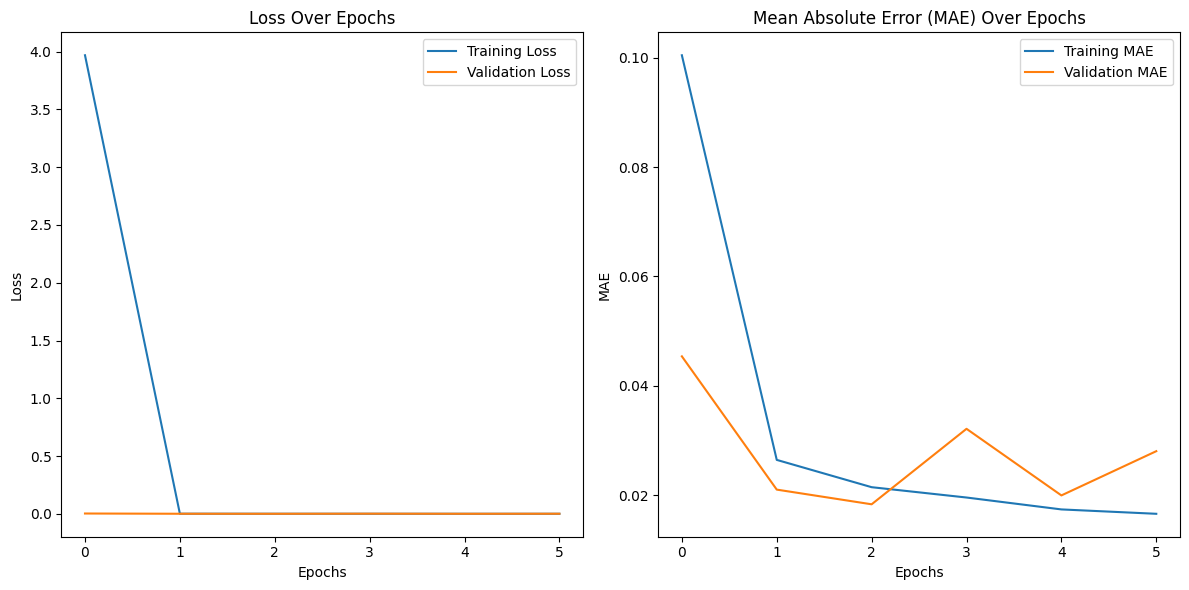

In [ ]:
# Plot training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prepare test data sequences for evaluation
X_test_list, y_test_list = [], []
for X_batch, y_batch in sequence_batch_generator(test_data_scaled, target_column='nat_demand', time_steps=time_steps, batch_size=batch_size):
    X_test_list.append(X_batch)
    y_test_list.append(y_batch)

# Concatenate test data batches
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Make predictions on test data
test_predictions = best_model.predict(X_test)

# Calculate error metrics
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)

print(f"Test MSE: {mse_test:.4f}, Test MAE: {mae_test:.4f}")

300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Test MSE: 0.0076, Test MAE: 0.0711


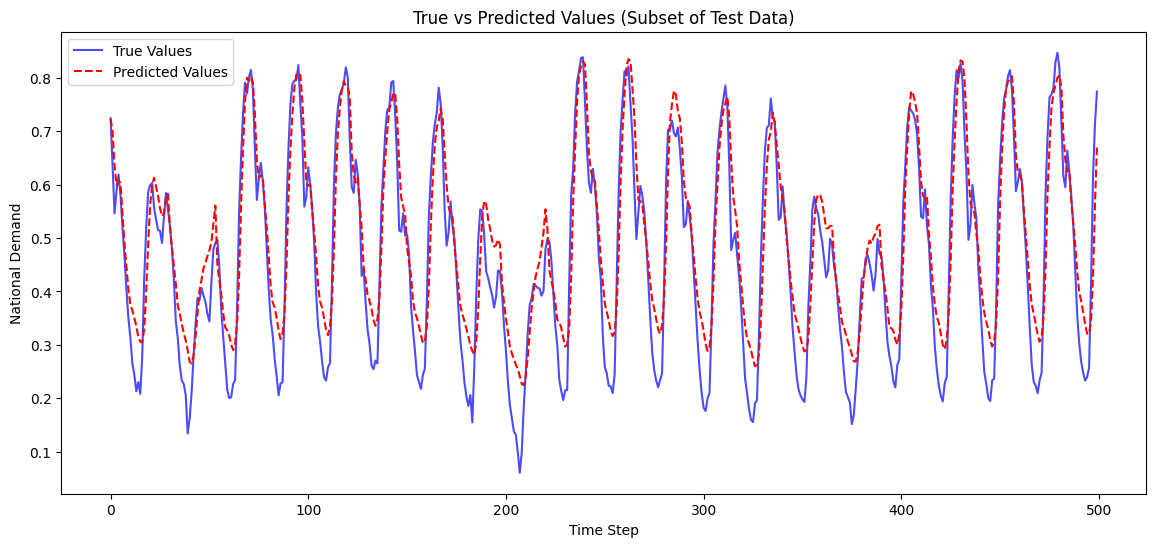

In [ ]:
# Define a subset of the data to visualize (for example, the first 500 time steps)
subset_size = 500
y_test_subset = y_test[:subset_size]
test_predictions_subset = test_predictions[:subset_size]

# Visualizing predictions vs true values on a smaller section
plt.figure(figsize=(14, 6))
plt.plot(y_test_subset, label='True Values', color='blue', alpha=0.7)
plt.plot(test_predictions_subset, label='Predicted Values', color='red', linestyle='--')
plt.title("True vs Predicted Values (Subset of Test Data)")
plt.xlabel("Time Step")
plt.ylabel("National Demand")
plt.legend()
plt.show()

# **STEP 4: RESULTS AND ANALYSIS**

### **Hyperparameter Tuning Results**

The hyperparameter tuning process identified several top-performing configurations, with the best trial featuring the following parameters:

* **LSTM Layer 1 Units:** 50

* **LSTM Layer 2 Units:** 50

* **Learning Rate:** 0.000441


This configuration achieved a validation loss of 0.001268, striking a strong balance between model complexity and generalization. Consistently, the top-performing models featured lower learning rates (near $1 \times 10^{-4}$), indicating the model’s benefit from smaller learning steps. Variations in LSTM units across layers also suggest adaptability to sequential data patterns.
<br><br>

### **Model Training Performance**

The selected model was trained using the optimal hyperparameters. Leveraging early stopping, training concluded after six epochs, with the best results recorded in epoch five:

* **Training Loss:** 0.00058047

* **Training MAE:** 0.0183

* **Validation Loss:** 0.0006984

* **Validation MAE:** 0.0200
<br><br>

### **Test Set Performance**

To evaluate generalization, the model was tested on a reserved test set. The following error metrics were recorded:

* **Mean Squared Error (MSE):** 0.0076

* **Mean Absolute Error (MAE):** 0.0711


These results indicate exceptional predictive performance, with minimal deviations between the predicted and actual electricity demand values. The low MSE of 0.0076 further highlights the model’s precision, particularly given the variability in demand within the dataset.
<br><br>

### **Insights and Observations**

1. **Learning Rate Impact:** The best trials consistently used lower learning rates, facilitating steady convergence without overshooting optimal values.

2. **Neuron Configuration:** Various combinations of LSTM units appeared in top models, suggesting that unit count had less influence on performance compared to learning rate.

3. **Validation Loss Trends:** Early stopping prevented overfitting, with validation loss stabilizing after epoch two.


The hyperparameter tuning process successfully identified an effective LSTM architecture, demonstrating robust predictive performance on both validation and test datasets. These results underscore the model’s ability to capture temporal patterns in electricity demand. Visually this is confirmed by a plot of a subset of True vs. Predicted Values, where there is good matching of values.


# **STEP 5: CONCLUSION**

In this project, we successfully applied deep learning techniques, specifically LSTM models, to predict electricity demand using historical data alongside key feature variables such as temperature, humidity, and wind speed. The best model, optimized through hyperparameter tuning, achieved strong predictive performance with a test MSE of 0.0076 and MAE of 0.0711. These results demonstrate the capability of LSTMs to effectively capture temporal dependencies and patterns, solidifying their suitability for time-series forecasting tasks.

The importance of hyperparameter tuning was evident, particularly in the optimization of learning rates and LSTM layer configurations, which significantly influenced the model’s performance. Early stopping further enhanced the training process by preventing overfitting, as evidenced by the stabilization of validation loss. Such robust forecasting models offer valuable tools for energy providers to make informed operational and strategic decisions.
<br><br>
### **Future Work**
To further refine the model and broaden its application scope, future research could explore the following directions:

* **Incorporating Additional Features:** Including external factors like energy prices, economic indicators, or more granular weather data could improve model accuracy and contextual relevance.

* **Exploring Advanced Architectures:** Investigating alternative models such as GRUs, Transformer architectures, or hybrid models may unlock new insights and boost predictive performance.

* **Cross-validation with Temporal Splits:** Leveraging techniques like TimeSeriesSplit can enhance the model’s ability to generalize across different time periods, ensuring robust performance in real-world scenarios.